In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import arviz as az
from jax import random
from numpyro.infer import MCMC, NUTS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
db = pd.read_csv("component-data-2c.csv")

# characterising components
components = db["index"].unique()
n_components = len(components)

x = db[['X1', 'X2', 'X3', 'X4', 'X5']].values
t = db["day"].values
y = db["integrity"].values
index = db["index"].values

n_features = x.shape[1]

In [40]:
def enhanced_model(t, x, index, y=None):

    # defining hyperpriors using normal distributions for mean and halfnormal for std
    u_mean = numpyro.sample("u_mean", dist.Normal(0.0, 500.0))
    u_std = numpyro.sample("u_std", dist.HalfNormal(100.0))
    v_mean = numpyro.sample("v_mean", dist.Normal(0.0, 3.0))
    v_std = numpyro.sample("v_std", dist.HalfNormal(3.0))

    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=(n_features,))

    # sampling through u and v for each unique component
    with numpyro.plate("components", n_components):
        u = numpyro.sample("u", dist.Normal(u_mean, u_std))
        v = numpyro.sample("v", dist.Normal(v_mean, v_std))

    # calculating the v + (w * x) part
    w_x = jnp.dot(x, w) 
    decay = v[index] + w_x
    
    # calculating the expected value
    mu = u[index] * jnp.exp(-decay * t / 100)
    
    # defining the noise prior
    sigma = numpyro.sample("sigma", dist.HalfNormal(10))
    
    # likelihood
    with numpyro.plate("obs", len(t)):
        numpyro.sample("y", dist.Normal(mu, sigma), obs=y)

In [41]:
# running MCMC
rng_key = random.PRNGKey(0)
kernel = NUTS(enhanced_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000)
mcmc.run(rng_key, t, x = x, index = index, y=y)

# extracting posterior samples
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:16<00:00, 362.14it/s, 31 steps of size 1.53e-01. acc. prob=0.89]


In [42]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.09      0.13      5.09      4.87      5.31   9073.66      1.00
      u[0]     94.24      2.19     94.24     90.48     97.71  10869.69      1.00
      u[1]     91.77      3.75     91.72     85.63     98.06   6456.71      1.00
      u[2]     98.43      2.04     98.39     95.13    101.70   7902.82      1.00
      u[3]     89.40      2.01     89.37     85.94     92.45   9974.25      1.00
      u[4]     89.72      3.34     89.75     84.41     95.36  10291.29      1.00
      u[5]     88.17      3.67     88.18     82.45     94.36   9704.90      1.00
      u[6]     91.00      2.95     90.97     86.18     95.81   8281.47      1.00
      u[7]     84.94      3.73     84.99     78.54     90.78   7345.47      1.00
      u[8]     89.99      2.92     90.00     85.18     94.81   6190.21      1.00
      u[9]     85.07      3.12     85.00     80.03     90.15   5836.49      1.00
     u[10]     86.43      2

In [ ]:
# get all components that have t=30
components_with_30 = db[db['day'] == 30]['ID'].unique()
filtered_db_linear = db[db['ID'].isin(components_with_30)]

def calculate_features(group):
    early_data = group[group['day'] <= 10]
    
    # time-based features
    features = {
        'mean_integrity': early_data['integrity'].mean(),
        'slope': np.polyfit(early_data['day'], early_data['integrity'], 1)[0],  # Trend
        'last_value': early_data[early_data['day'] == 10]['integrity'].iloc[0] if 10 in early_data['day'].values else np.nan,
        'X1': group['X1'].iloc[0],  # Static features
        'X2': group['X2'].iloc[0],
        'X3': group['X3'].iloc[0],
        'X4': group['X4'].iloc[0],
        'X5': group['X5'].iloc[0]
    }
    return pd.Series(features)

# create feature matrix and target
features_linear = filtered_db_linear.groupby('ID').apply(calculate_features).dropna()
targets = filtered_db_linear[filtered_db_linear['day'] == 30].set_index('ID')['integrity']
model_data = features_linear.join(targets, how='inner')  # Ensure matching IDs

X_linear = model_data.drop(columns=['integrity'])
y_linear = model_data['integrity']
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

/var/folders/4m/7mxbnmms1ls6mb6d3b7tcd640000gn/T/ipykernel_71474/2809961873.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_linear = filtered_db_linear.groupby('ID').apply(calculate_features).dropna()


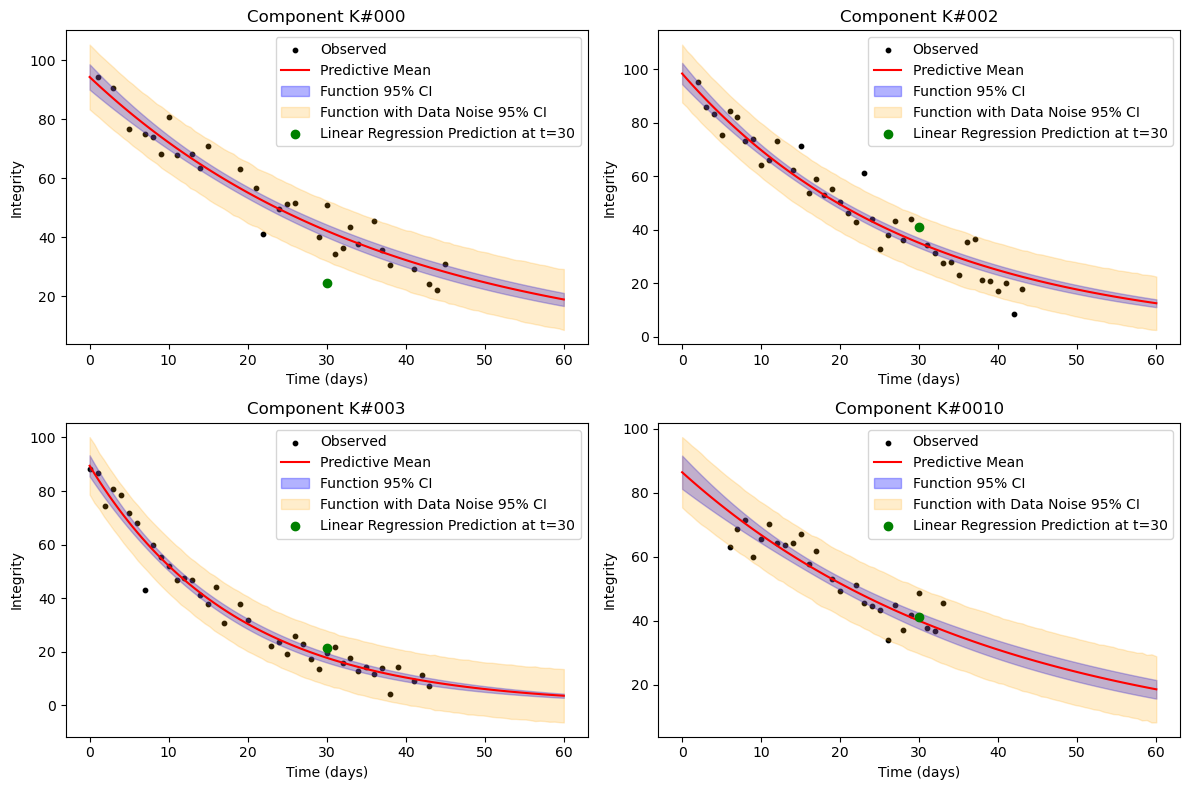

In [ ]:
# make predictions at t=30 for the components you are plotting
linear_preds_at_30 = model.predict(X_linear)

# define component IDs for plotting
component_ids = [0, 2, 3, 10]
t_plot = np.linspace(0, 60, 100)

# prepare the plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, component_id in enumerate(component_ids):
    ax = axs[i]

    # mask for the current component
    mask = (index == component_id)
    
    # get the specific component's x data and calculate the prediction mean
    x_component = x[mask]
    x_plot = x_component.mean(axis=0)

    u_samples = posterior_samples["u"][:, component_id]
    v_samples = posterior_samples["v"][:, component_id]
    w_samples = posterior_samples["w"]
    sigma_samples = posterior_samples["sigma"]

    n_samples = len(u_samples)
    mu_samples = np.zeros((n_samples, len(t_plot)))  # function estimate (no noise)
    y_samples = np.zeros_like(mu_samples)            # predictive samples (with noise)

    for j in range(n_samples):
        decay = v_samples[j] + np.dot(x_plot, w_samples[j])
        mu = u_samples[j] * np.exp(-decay * t_plot / 100)
        mu_samples[j, :] = mu
        y_samples[j, :] = np.random.normal(mu, sigma_samples[j])

    # predictive mean calculation
    mean_prediction = np.mean(mu_samples, axis=0)

    # function uncertainty with no noise
    std_func = np.std(mu_samples, axis=0)
    lower_func = mean_prediction - 1.96 * std_func
    upper_func = mean_prediction + 1.96 * std_func

    # function uncertainty with data noise
    std_total = np.std(y_samples, axis=0)
    lower_total = mean_prediction - 1.96 * std_total
    upper_total = mean_prediction + 1.96 * std_total

    # plot the observed data
    ax.scatter(t[mask], y[mask], color='black', label="Observed", s=10)
    ax.plot(t_plot, mean_prediction, color='red', label="Predictive Mean")

    # plot function uncertainty (narrower band)
    ax.fill_between(t_plot, lower_func, upper_func, color='blue', alpha=0.3, label="Function 95% CI")

    # plot total predictive uncertainty (wider band)
    ax.fill_between(t_plot, lower_total, upper_total, color='orange', alpha=0.2, label="Function with Data Noise 95% CI")

    # get the index of the current component_id
    component_index = np.where(model_data.index == f'K#{component_id:04d}')[0][0]

    # plot linear regression prediction at t=30 for the component
    ax.scatter(30, linear_preds_at_30[component_index], color='green', label="Linear Regression Prediction at t=30", zorder=5)

    ax.set_title(f"Component K#00{component_id}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Integrity")
    ax.legend()

plt.tight_layout()
plt.savefig("enchanced_model_fit_with_lr.png", dpi=300)
plt.show()

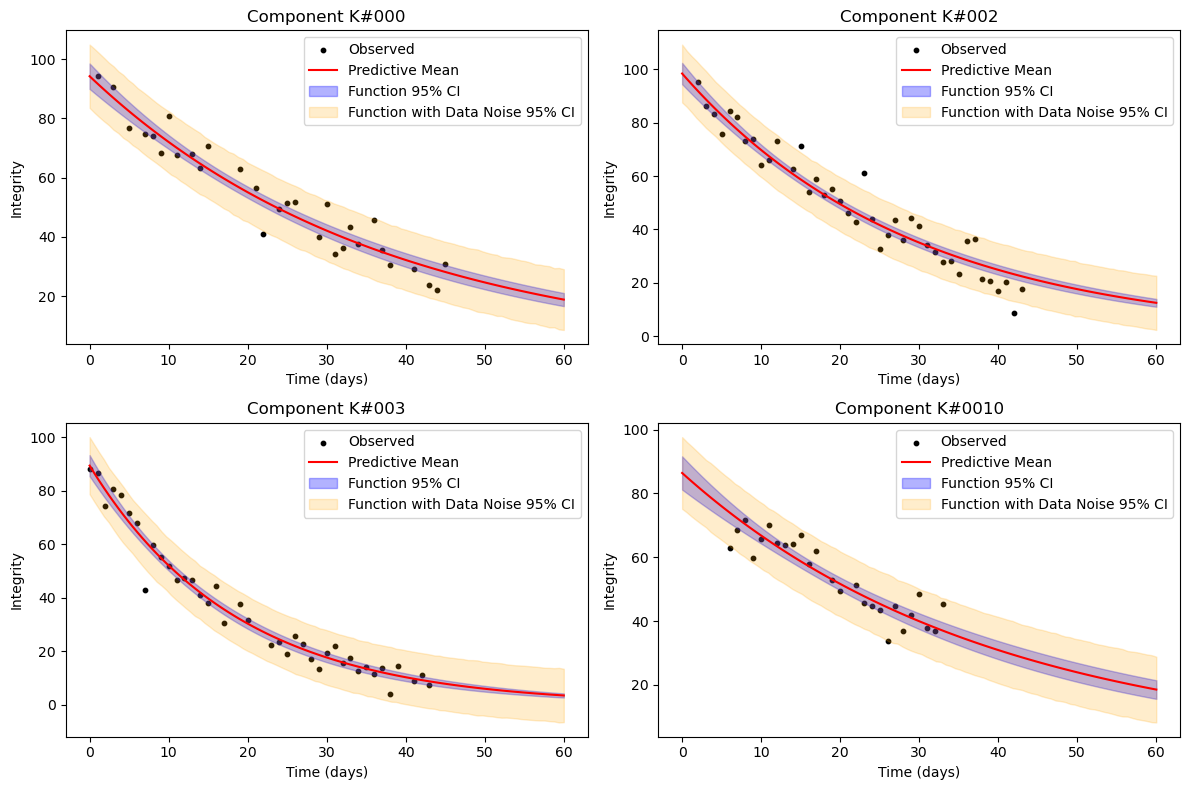

In [ ]:
component_ids = [0, 2, 3, 10]
t_plot = np.linspace(0, 60, 100)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, component_id in enumerate(component_ids):
    ax = axs[i]
    mask = (index == component_id)

    x_component = x[mask]
    x_plot = x_component.mean(axis=0)

    u_samples = posterior_samples["u"][:, component_id]
    v_samples = posterior_samples["v"][:, component_id]
    w_samples = posterior_samples["w"]
    sigma_samples = posterior_samples["sigma"]

    n_samples = len(u_samples)
    mu_samples = np.zeros((n_samples, len(t_plot)))  # function estimate (no noise)
    y_samples = np.zeros_like(mu_samples)            # predictive samples (with noise)

    for j in range(n_samples):
        decay = v_samples[j] + np.dot(x_plot, w_samples[j])
        mu = u_samples[j] * np.exp(-decay * t_plot / 100)
        mu_samples[j, :] = mu
        y_samples[j, :] = np.random.normal(mu, sigma_samples[j])

    # predictive mean calculation
    mean_prediction = np.mean(mu_samples, axis=0)

    # function uncertainty with no noise
    std_func = np.std(mu_samples, axis=0)
    lower_func = mean_prediction - 1.96 * std_func
    upper_func = mean_prediction + 1.96 * std_func

    # function uncertainty with data noise
    std_total = np.std(y_samples, axis=0)
    lower_total = mean_prediction - 1.96 * std_total
    upper_total = mean_prediction + 1.96 * std_total

    ax.scatter(t[mask], y[mask], color='black', label="Observed", s=10)
    ax.plot(t_plot, mean_prediction, color='red', label="Predictive Mean")

    # function uncertainty (narrower band)
    ax.fill_between(t_plot, lower_func, upper_func, color='blue', alpha=0.3, label="Function 95% CI")

    # total predictive uncertainty (wider band)
    ax.fill_between(t_plot, lower_total, upper_total, color='orange', alpha=0.2, label="Function with Data Noise 95% CI")

    ax.set_title(f"Component K#00{component_id}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Integrity")
    ax.legend()

plt.tight_layout()
plt.savefig("enchanced_model_fit.png", dpi=300)
plt.show()